In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import scienceplots
import random

from utils import combine_meta_test

## Score vs. Design Number

In [2]:
Tag_tests = pd.read_pickle('Taguchi_test_dict.pkl') # All 32 Taguchi tests
Tag_meta = pd.read_csv('Tag_d_params.csv') # Meta data for Taguchi tests
Tag_df = combine_meta_test(Tag_meta, Tag_tests)
Tag_df = Tag_df.dropna(subset=['max_current']) # Remove any incomplete tests

In [3]:
# recreate initialization
seed = 116
Number_of_initialization_trials = 10
random.seed(seed)
choices = random.sample(range(0, 32), Number_of_initialization_trials)

In [4]:
# load meta and test data for BO designs
BO_meta_file = 'BO_designs/BO_d_params.csv' #.csv
OS_meta_file = 'BO_designs/BO_OneShot_meta_vals.csv' #.csv
All_OS_meta_file = 'BO_designs/BO_All_OneShot_meta_vals.csv' #.csv
BO_test_file = 'BayzOp_test_dict.pkl' #.pkl

BO_d_params = pd.read_csv(BO_meta_file) # all BO designs
OS_d_params = pd.read_csv(OS_meta_file) # all BO designs
All_OS_d_params = pd.read_csv(All_OS_meta_file)
BO_tests = pd.read_pickle(BO_test_file)
BO_df = combine_meta_test(BO_d_params, BO_tests) # combine meta and test data
OS_df = combine_meta_test(OS_d_params, BO_tests) # combine meta and test data
All_OS_df = combine_meta_test(All_OS_d_params, BO_tests) # combine meta and test data

In [5]:
# add a 'Score' to Tag_df
for i, row in Tag_df.iterrows():
    if row['max_dxt'] >= 0.95:
        max_dxt = 1e12
    else:
        max_dxt = row['max_dxt']
    Tag_df.at[i, 'Score'] = row['gear_ratio'] / max_dxt

# add a 'Score' to BO_df
for i, row in BO_df.iterrows():
    if row['max_dxt'] >= 0.95:
        max_dxt = 1e12
    else:
        max_dxt = row['max_dxt']
    BO_df.at[i, 'Score'] = row['gear_ratio'] / max_dxt

# add a 'Score' to OS_df
for i, row in OS_df.iterrows():
    if row['max_dxt'] >= 0.95:
        max_dxt = 1e12
    else:
        max_dxt = row['max_dxt']
    OS_df.at[i, 'Score'] = row['gear_ratio'] / max_dxt

for i, row in All_OS_df.iterrows():
    if row['max_dxt'] >= 0.95:
        max_dxt = 1e12
    else:
        max_dxt = row['max_dxt']
    All_OS_df.at[i, 'Score'] = row['gear_ratio'] / max_dxt

In [6]:
init_df = Tag_df.iloc[choices]
# arrange by design number
init_df = init_df.sort_values(by='Design')

In [7]:
init_df['Design'] = range(0, len(init_df))

In [8]:
# combine init and BO data, init then BO:
combined_df = pd.concat([init_df, BO_df], ignore_index=True)


In [9]:
Tag_df['Design'] = Tag_df['Design'] - 1

In [10]:
BO_df

,Design,material,lubricant,z_sh,z_r2,x_s,x_r2,Cl,g_thickness_h,p1_offset,p2_offset,gear_ratio,max_current,max_dxt,Score
0,10,ABS,LI,7,77,-0.357144,0.760397,3.000000e-04,6,2,2,104.732394,1087.8750,0.964809,1.047324e-10
1,11,ABS,NaN,8,76,-0.401274,0.063233,3.000000e-04,6,2,-1,26.281593,228.2625,0.236315,1.112144e+02
2,12,PLA,PTFE,6,76,0.389719,0.252311,7.012641e-06,3,1,2,71.169492,988.7500,0.964809,7.116949e-11
3,13,ABS,LI,9,76,0.796491,-0.108898,3.000000e-04,6,1,2,38.926829,264.1500,0.292551,1.330598e+02
4,14,ABS,LI,7,79,0.651174,-0.166665,0.000000e+00,3,0,0,53.880184,1088.7500,0.964809,5.388018e-11
5,15,PLA,LI,6,76,-0.648760,0.441726,6.337800e-05,3,2,1,63.668269,294.3750,0.256266,2.484461e+02
6,16,PLA,LI,6,76,0.331754,0.567660,3.000000e-04,6,2,1,56.743243,240.0000,0.255963,2.216855e+02
7,17,PLA,LI,6,76,-0.800000,0.787381,2.978554e-08,6,2,2,112.228814,1137.5000,0.964809,1.122288e-10
8,18,ABS,LI,6,76,0.249718,-0.250000,5.055807e-05,3,2,2,49.692308,249.5250,0.240293,2.067986e+02
9,19,PLA,NaN,6,76,0.053514,-0.093661,1.636058e-04,3,-1,2,118.326733,395.0000,0.964809,1.183267e-10


In [11]:
OS_df

,Design,material,lubricant,z_sh,z_r2,x_s,x_r2,Cl,g_thickness_h,p1_offset,p2_offset,gear_ratio,max_current,max_dxt,Score
0,32,PLA,LI,6,76,-0.58722,-0.076418,0.000033,6,2,2,63.668269,180.3125,0.140137,454.329237


In [12]:
All_OS_df

,Design,material,lubricant,z_sh,z_r2,x_s,x_r2,Cl,g_thickness_h,p1_offset,p2_offset,gear_ratio,max_current,max_dxt,Score
0,66,ABS,PTFE,6,76,-0.308943,0.274644,0.000297,5,2,-1,36.914286,0.0,0.30045,122.863464


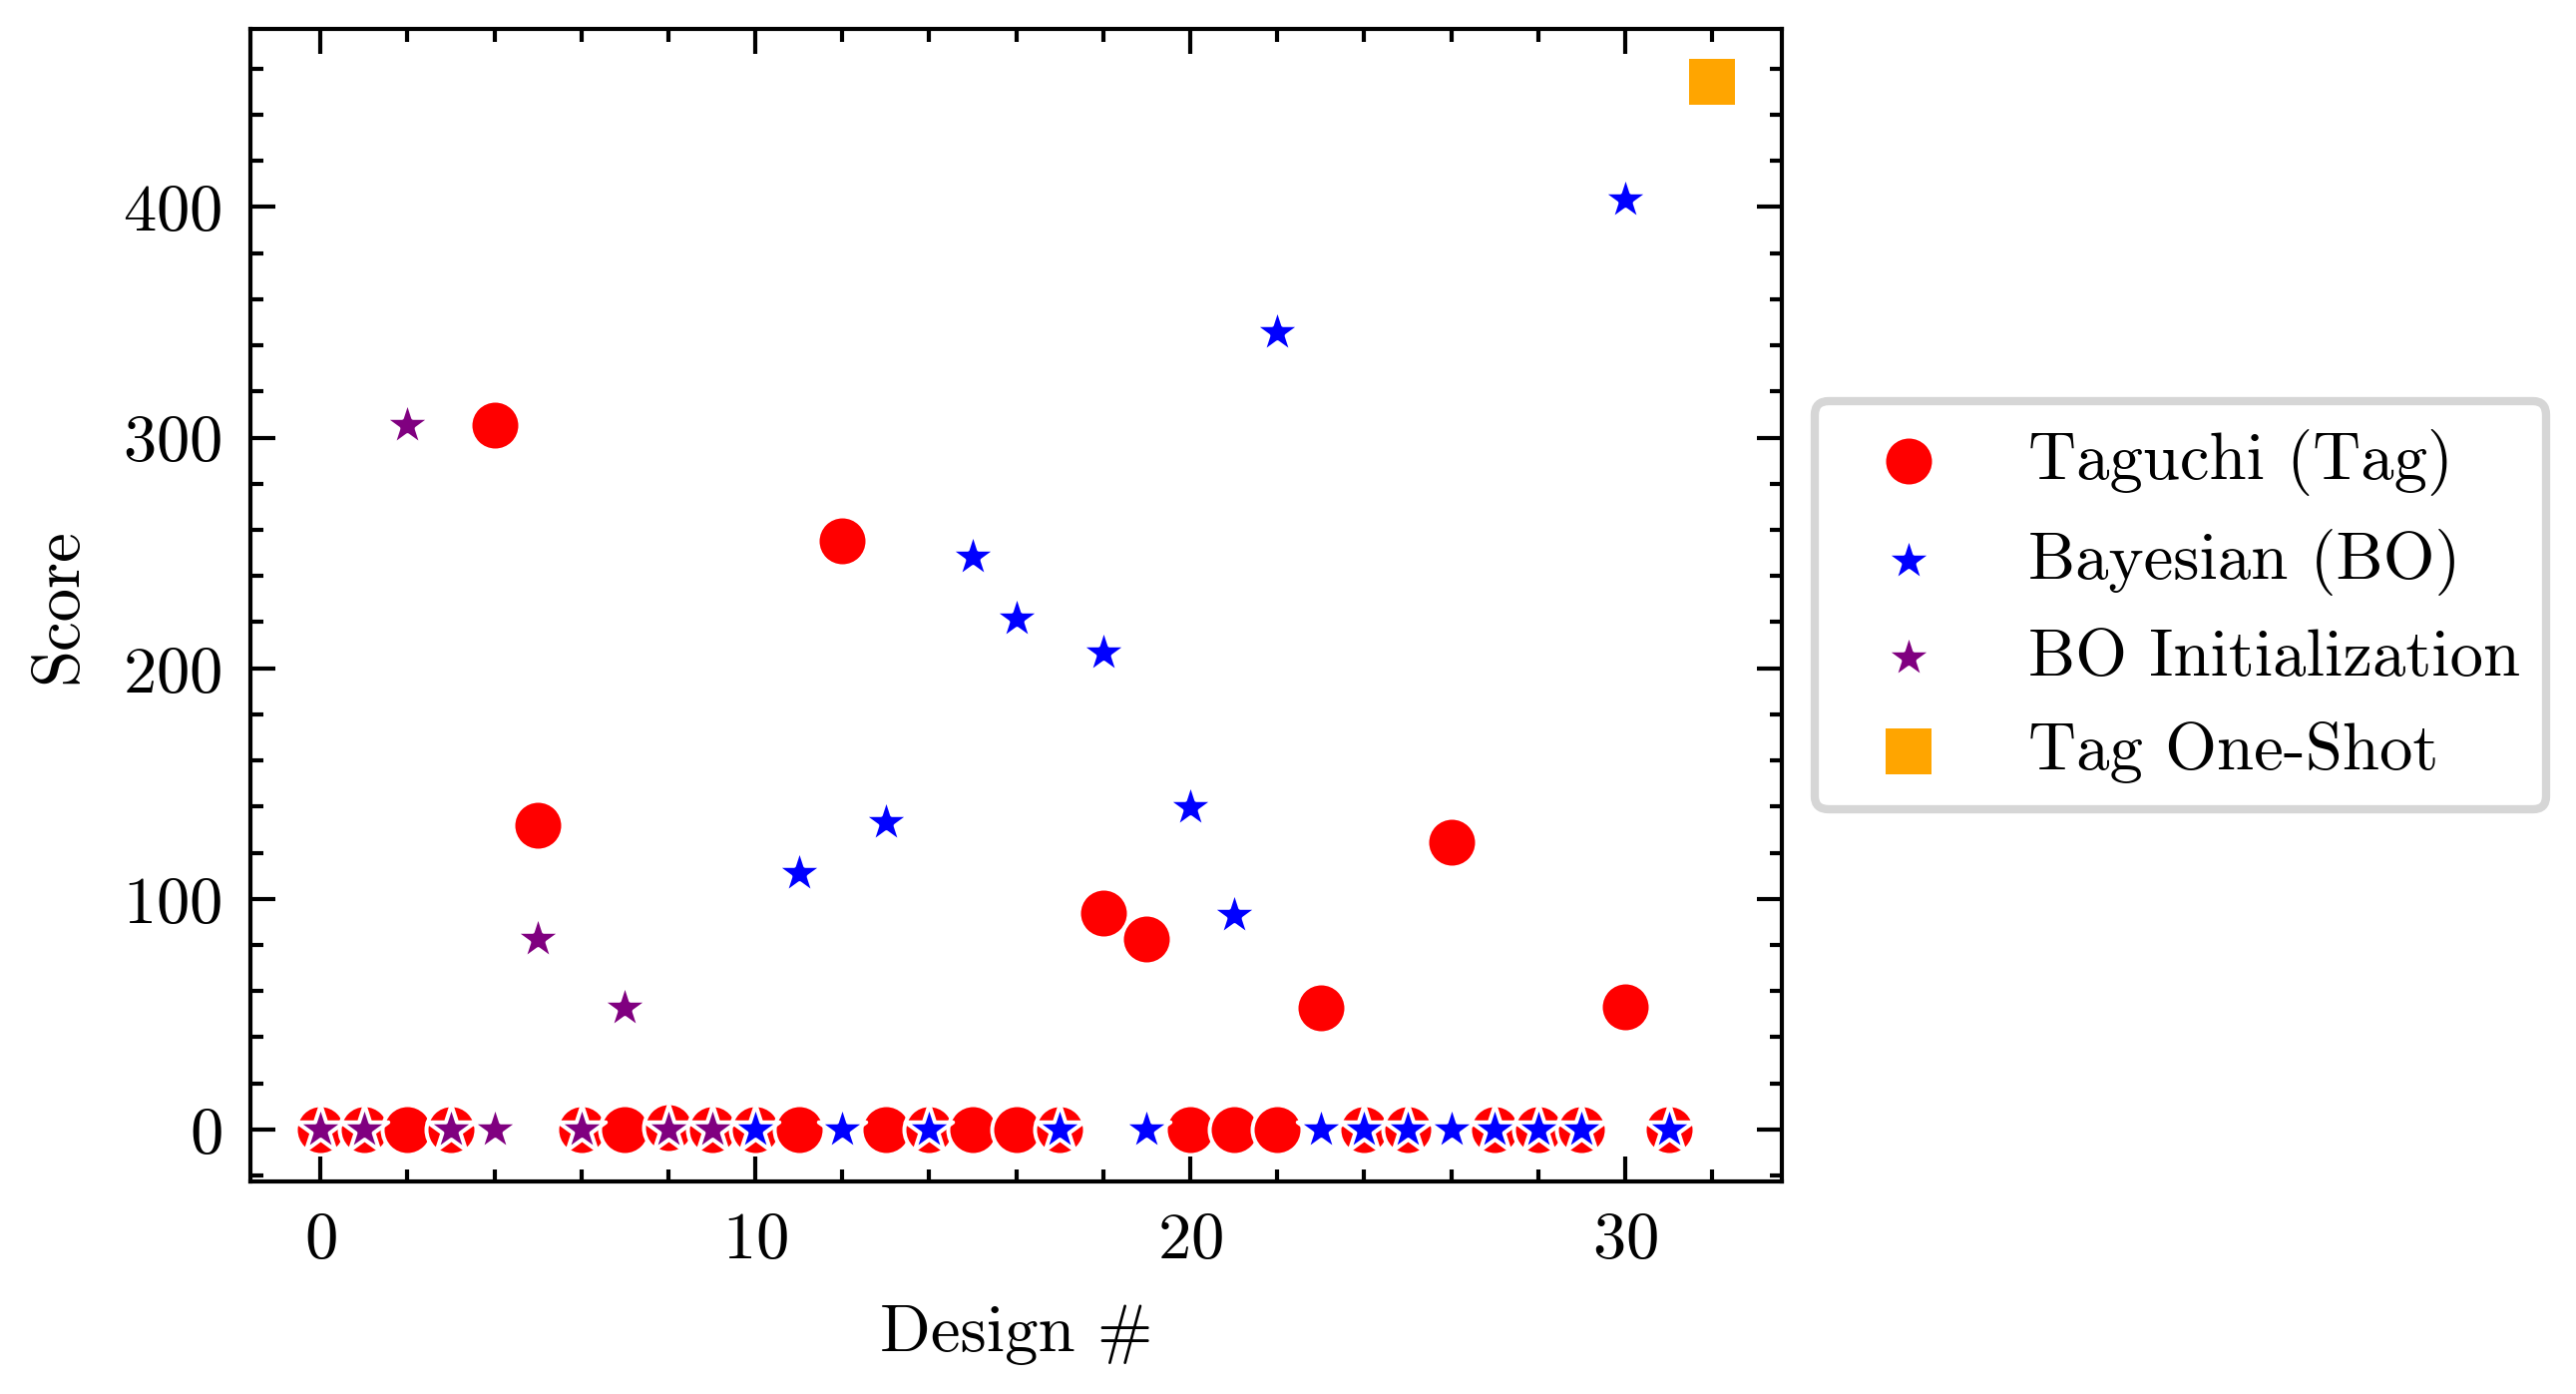

In [13]:
# plot the scores by the test numbers for the two methods on the same plot
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.scatterplot(data=Tag_df, x='Design', y='Score', color='r', marker='o', label='Taguchi (Tag)')
    sns.scatterplot(data=BO_df, x='Design', y='Score', color='b', marker = '*', label = 'Bayesian (BO)')
    sns.scatterplot(data=init_df, x='Design', y='Score', color='purple', marker='*', label='BO Initialization')
    sns.scatterplot(data=OS_df, x='Design', y='Score', color='orange', marker = 's', label = 'Tag One-Shot')
    # sns.scatterplot(data=All_OS_df, x=32, y='Score', color='green', marker = 's', label = 'Tag+BO One-Shot')
    # show legend with a border outside of the plot
    # plt.legend(loc='upper left', frameon=True, borderpad=1, borderaxespad=1)
    ax.legend(loc='center left', bbox_to_anchor=(1.0,0.5), frameon=True)
    ax.set_xlabel('Design #')
    plt.show()

## Score vs. Model Accuracy & Uncertainty

In [14]:
all_BO_acc = pickle.load(open('all_BO_acc_0.3.pkl','rb'))
all_tag_error = pickle.load(open('all_tag_error_0.3.pkl','rb'))
all_BO_SEM = pickle.load(open('all_BO_SEM_0.3.pkl','rb'))
all_tag_SEM = pickle.load(open('all_tag_SEM_0.3.pkl','rb'))

In [15]:
avg_BO_SEM = []
avg_BO_error = []
for ind in range(len(all_BO_SEM)):
    bo_sems = [x['Max_torque_gear_ratio_product'][1] for x in all_BO_SEM[ind]]
    bo_errors = all_BO_acc[ind][0]
    avg_BO_SEM.append(np.mean(bo_sems))
    avg_BO_error.append(np.mean(bo_errors))

BO_scores = np.array(BO_df['Score'][np.isfinite(BO_df['Score'])])

In [16]:
# adjust for acquiring 2 at a time
new_avg_BO_SEM = []
new_avg_BO_error = []
for i in range(len(avg_BO_SEM)):
    if i % 2 == 0:  # For even indices
        new_avg_BO_SEM.append(avg_BO_SEM[i])
        new_avg_BO_error.append(avg_BO_error[i])
    else:  # For odd indices
        new_avg_BO_SEM.append(avg_BO_SEM[i-1])  # Use previous even value
        new_avg_BO_error.append(avg_BO_error[i-1])

# normalize
new_avg_BO_SEM = new_avg_BO_SEM / np.max(new_avg_BO_SEM)
new_avg_BO_error = new_avg_BO_error / np.max(new_avg_BO_error)

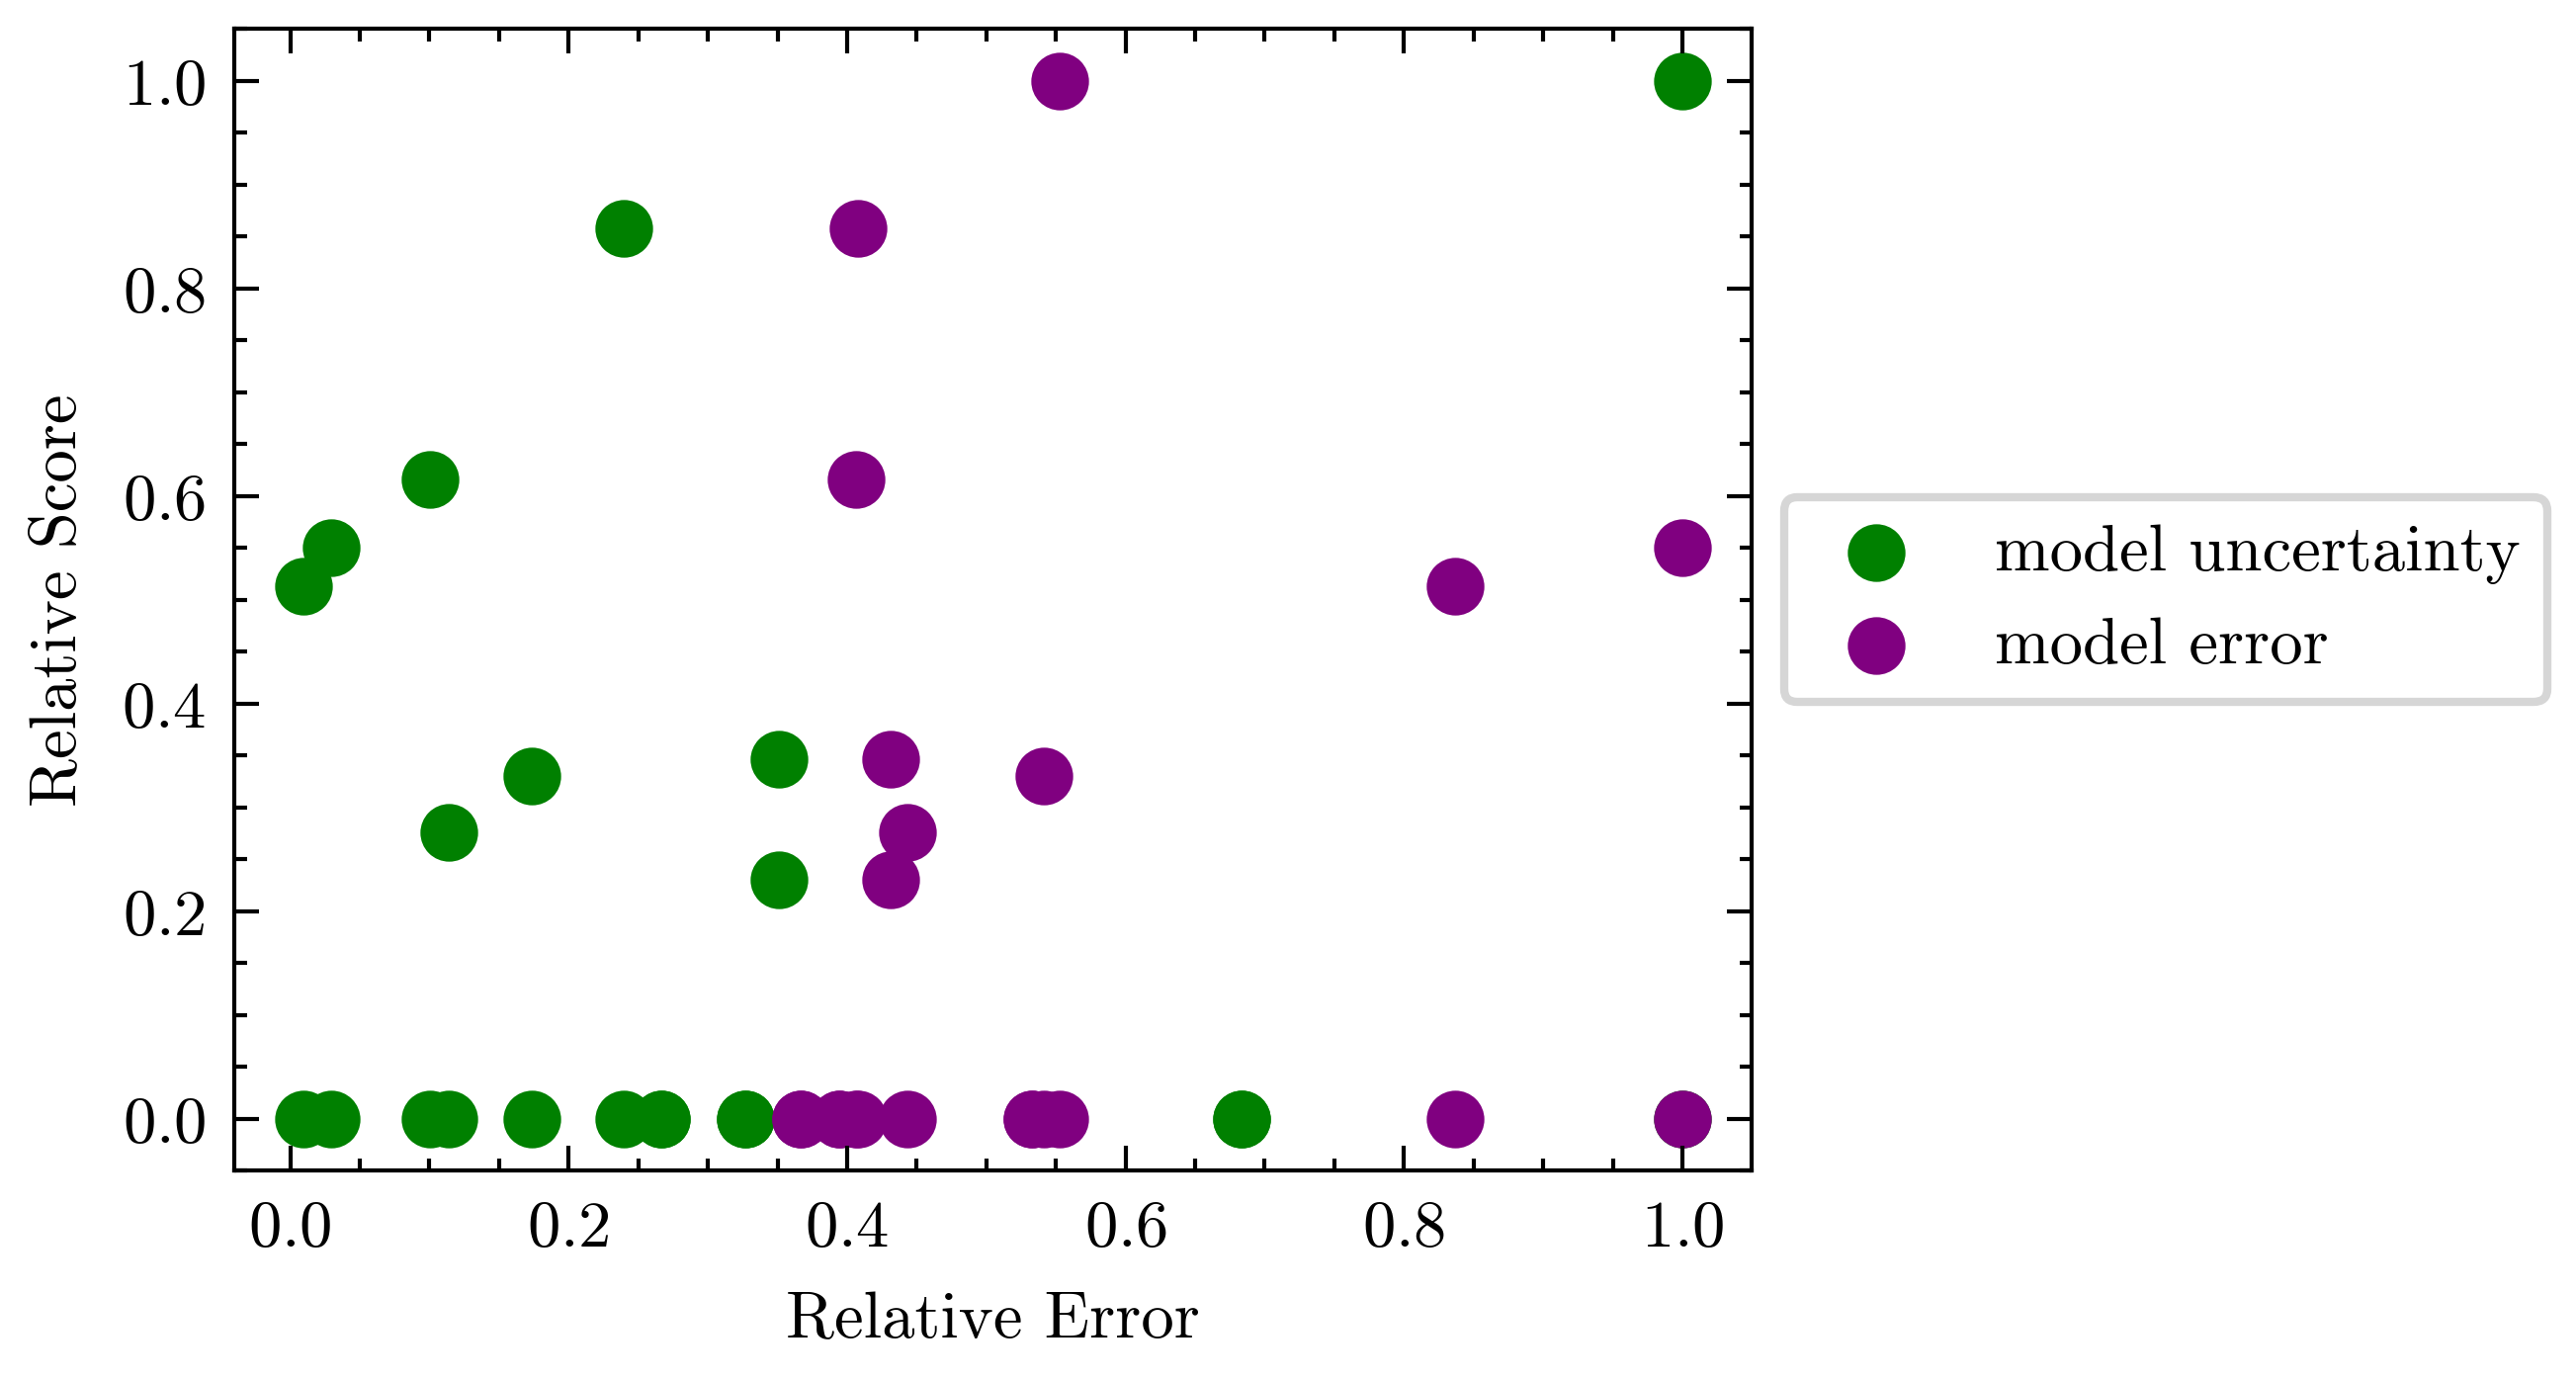

In [17]:
# plot the scores by the errors and accuracies (2 plots)
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # ax.scatter(avg_BO_SEM/np.max(avg_BO_SEM), BO_scores/np.max(BO_scores), color = 'b', label= 'model uncertainty')
    # ax.scatter(avg_BO_error/np.max(avg_BO_error), BO_scores/np.max(BO_scores), color = 'r', label = 'model error')
    ax.scatter(new_avg_BO_SEM, BO_scores/np.max(BO_scores), color = 'g', label= 'model uncertainty')
    ax.scatter(new_avg_BO_error, BO_scores/np.max(BO_scores), color = 'purple', label = 'model error')
    
    ax.legend(loc='center left', bbox_to_anchor=(1.0,0.5), frameon=True)
    ax.set_xlabel('Relative Error')
    ax.set_ylabel('Relative Score')
    plt.show()

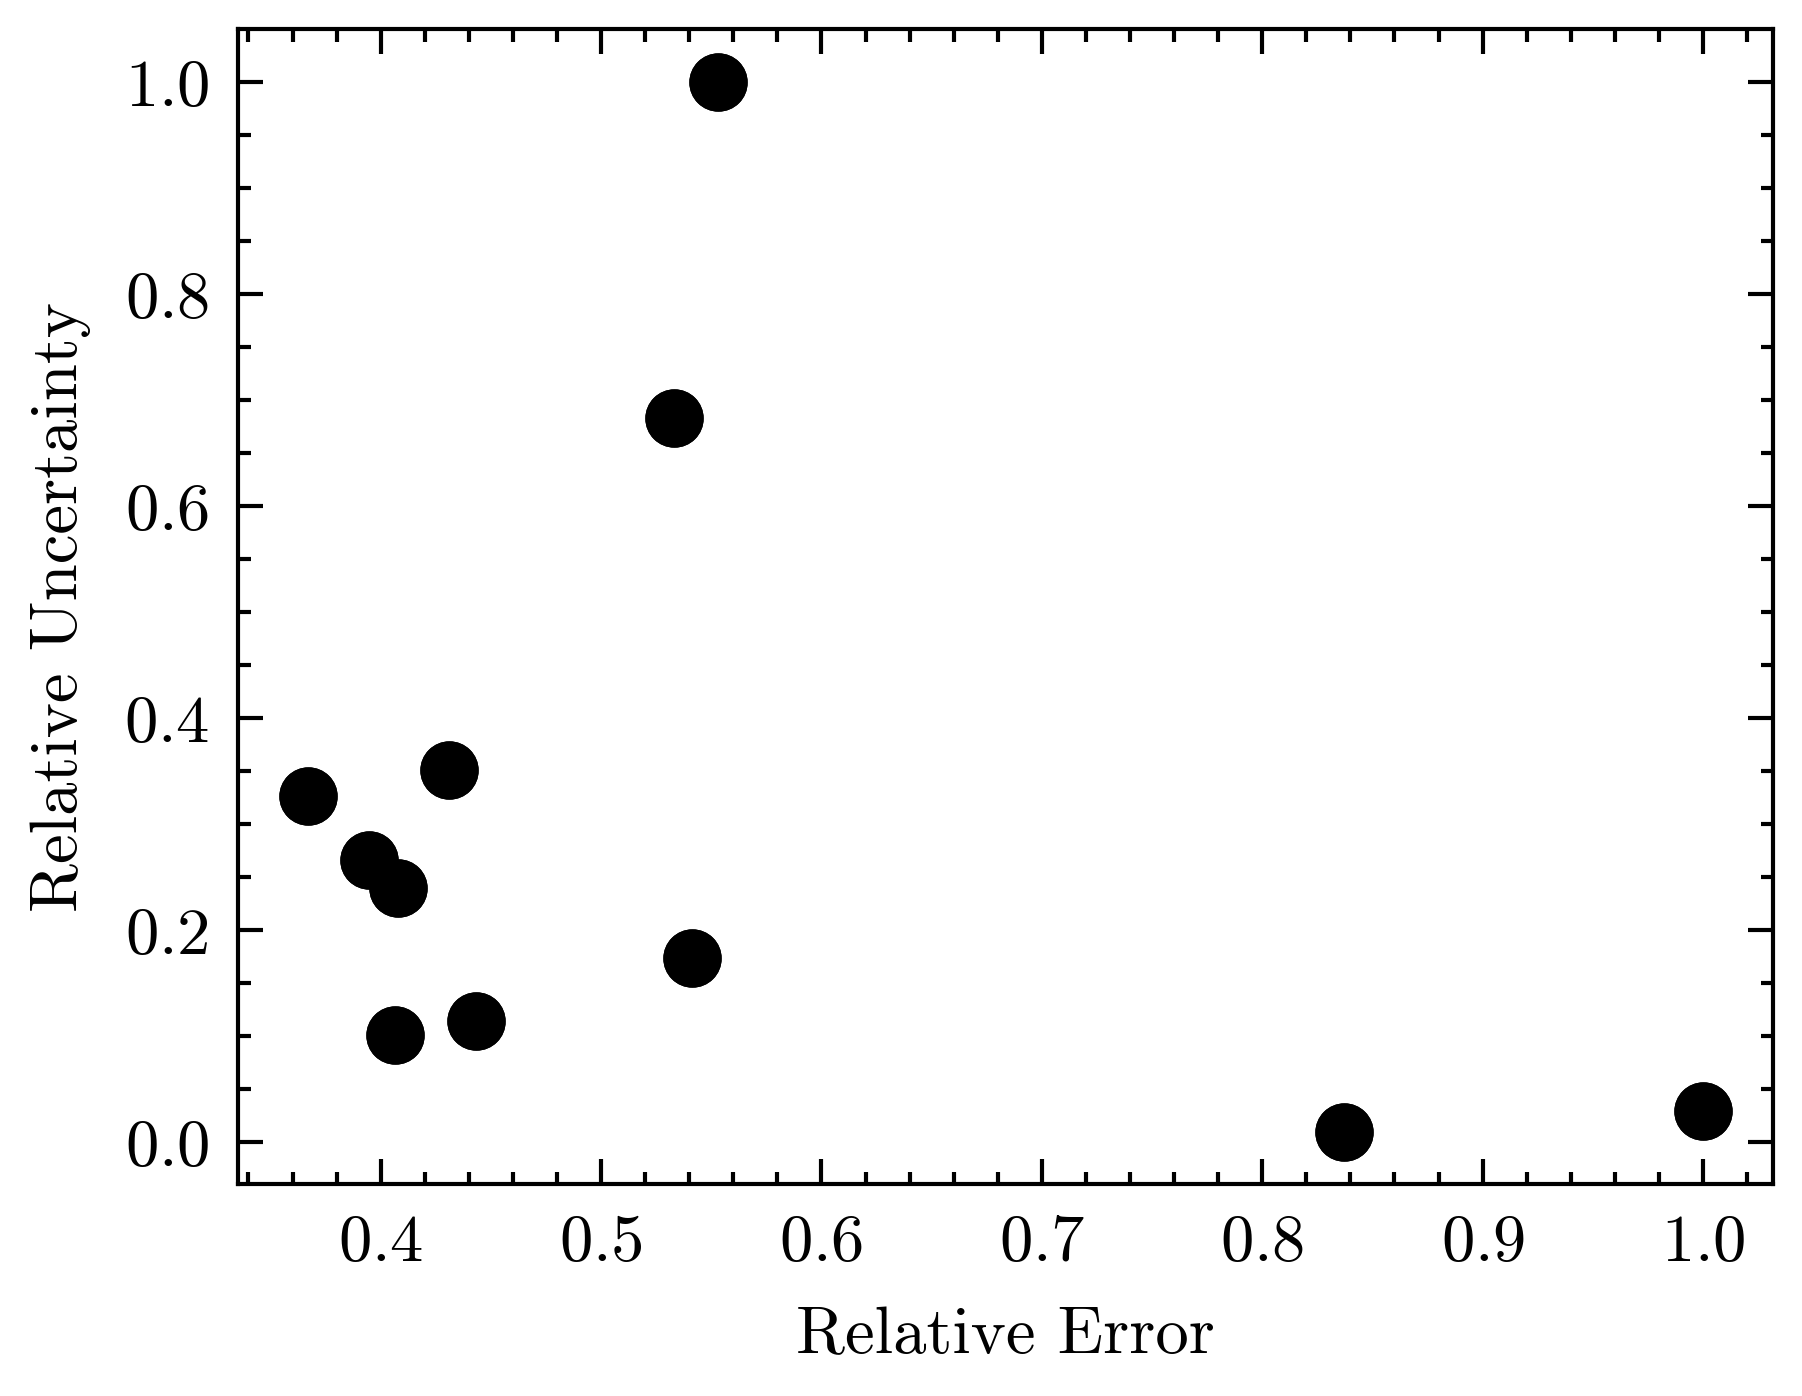

In [18]:
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # ax.scatter(avg_BO_SEM/np.max(avg_BO_SEM), BO_scores/np.max(BO_scores), color = 'b', label= 'model uncertainty')
    # ax.scatter(avg_BO_error/np.max(avg_BO_error), BO_scores/np.max(BO_scores), color = 'r', label = 'model error')
    ax.scatter(new_avg_BO_error,new_avg_BO_SEM)
    ax.set_xlabel('Relative Error')
    ax.set_ylabel('Relative Uncertainty')
    plt.show()

# VALVE

In [19]:
valve_tag = pd.read_csv('valve_tag_d_params.csv')
valve_BO = pd.read_csv('valve_BO_d_params.csv')
## Add manually instead of using below.
valve_tag_df = valve_tag.copy()
valve_BO_df = valve_BO.copy()
# Remove any incomplete tests
valve_tag_df = valve_tag_df.dropna(subset=['crack_pressure'])
valve_BO_df = valve_BO_df.dropna(subset=['crack_pressure'])

In [20]:
valve_tag_df['crack_error'] = 100*np.abs(valve_tag_df['crack_pressure'] - 0.1)
valve_tag_df['ss_error'] = 100*np.abs(valve_tag_df['ss_P_diff'] - 0.05)
valve_BO_df['crack_error'] = 100*np.abs(valve_BO_df['crack_pressure'] - 0.1)
valve_BO_df['ss_error'] = 100*np.abs(valve_BO_df['ss_P_diff'] - 0.05)

In [29]:
seed = 116
random.seed(seed)
# Reorder the Taguchi tests randomly
order = random.sample(range(0, len(valve_tag)), len(valve_tag))
# Specify number of init points and take first n from re-ordered
num_init = 5
init = order[:num_init]
valve_init_df = valve_tag_df.iloc[init]
# non-init-df:
valve_non_init_df = valve_tag_df.copy().drop(index=init)

In [22]:
valve_tag_df

,Design,material,thickness,dome_height,cut_length,cut_geometry,crack_pressure,ss_P_diff,crack_error,ss_error
0,1,DS20,0.75,2.2,2.00,triple,0.5110,0.1480,41.10,9.80
1,2,DS20,0.20,1.0,0.75,X,0.1040,0.1000,0.40,5.00
2,3,DS20,0.50,3.8,1.00,slit,1.0000,1.0000,90.00,95.00
3,4,DS20,1.50,1.5,1.50,triple,1.0000,1.0000,90.00,95.00
4,5,E0030,0.75,1.0,1.00,triple,0.0918,0.0800,0.82,3.00
5,6,E0030,0.20,2.2,1.50,slit,0.0466,0.0448,5.34,0.52
6,7,E0030,0.50,1.5,2.00,X,0.0820,0.0650,1.80,1.50
7,8,E0030,1.50,3.8,0.75,triple,0.3820,0.3393,28.20,28.93
8,9,DS10,0.75,3.8,1.50,X,1.0000,1.0000,90.00,95.00
9,10,DS10,0.20,1.5,1.00,triple,0.0100,0.0100,9.00,4.00


In [23]:
valve_BO_df

,Design,material,thickness,dome_height,cut_length,cut_geometry,crack_pressure,ss_P_diff,crack_error,ss_error
0,5,DS20,0.200000,1.339251,0.750000,X,0.01000,0.0350,9.000,1.50
1,6,DS20,0.200000,1.126773,0.752417,X,0.02425,0.0318,7.575,1.82
2,7,DS20,0.606153,1.051526,0.750000,X,0.17500,0.1500,7.500,10.00
3,8,DS20,0.743116,1.118785,0.798080,X,0.27000,0.2300,17.000,18.00


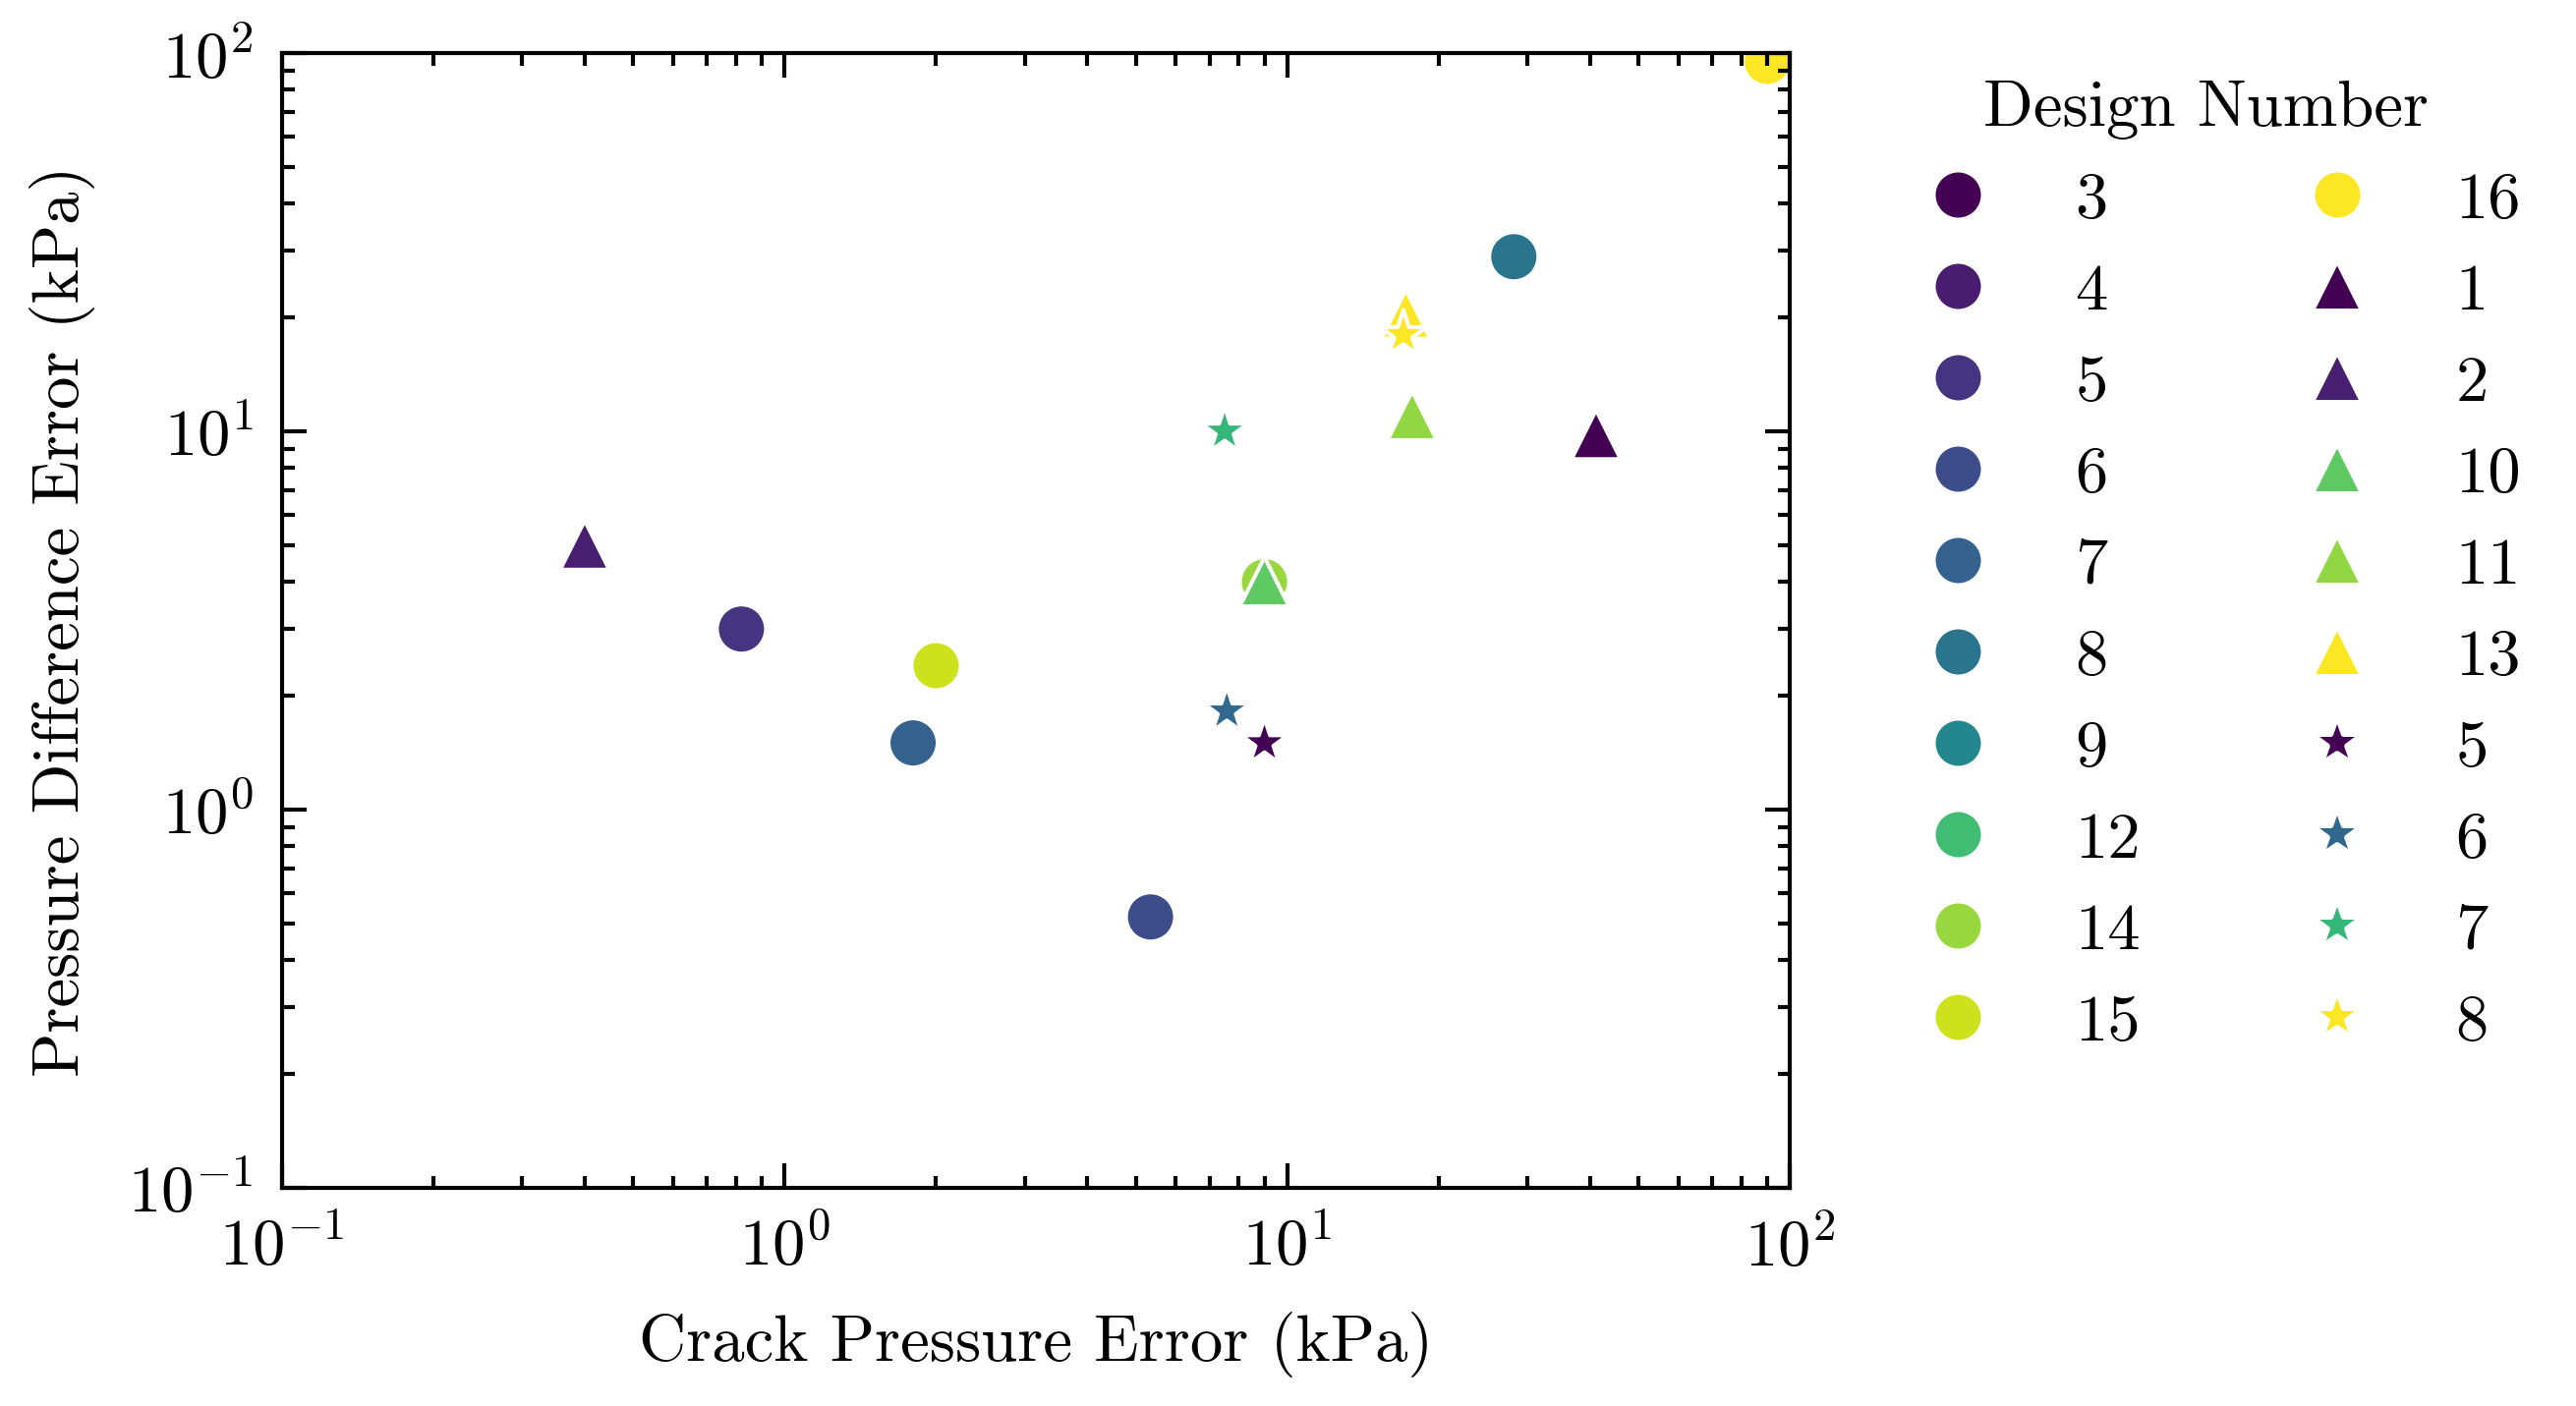

In [34]:
# combine the plots of the two dataframes - seperate colors and legends for each
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Use a color scale for different tests (e.g., by 'Design' or another column)
    # alter the marker if the value is in the BO init
    scatter = sns.scatterplot(
        data=valve_non_init_df,
        x='crack_error',
        y='ss_error',
        hue='Design',           
        palette='viridis',      
        marker='o',
        ax=ax,
        legend='full'
    )
    # alter the marker if the value is in the BO init
    scatter = sns.scatterplot(
        data=valve_init_df,
        x='crack_error',
        y='ss_error',
        hue='Design',           
        palette='viridis',      
        marker='^',
        ax=ax,
        legend='full'
    )   
    scatter = sns.scatterplot(
        data=valve_BO_df,
        x='crack_error',
        y='ss_error',
        hue='Design',           
        palette='viridis', #'tab10',      
        marker='*',
        ax=ax,
        legend='full'
    )
    ax.set_xlabel('Crack Pressure Error (kPa)')
    ax.set_ylabel('Pressure Difference Error (kPa)')
    # ax.axhline(y=0.05, color='r', linestyle='--', label='Target P_diff = 0.05')
    # ax.axvline(x=0.10, color='g', linestyle='--', label='Target Crack Pressure = 0.10')
    # Place the legend outside the plot for clarity
    ax.legend(title='Design Number', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2)
    # log scale axes
    ax.set_xscale('log')
    ax.set_yscale('log')
    # axes 0-100
    ax.set_xlim(0.1, 100)
    ax.set_ylim(0.1, 100)
    # plt.tight_layout()
    plt.show()
